In [1]:
from datasets import DatasetDict, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    T5Tokenizer,
    T5ForConditionalGeneration,
    T5Config,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import tqdm
import nltk
import csv
import time
import gc
import GPUtil
import evaluate
import pprint
from numba import cuda
import optuna
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

2023-10-24 19:59:43.028485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 19:59:43.028540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 19:59:43.029945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garykong. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
os.environ["WANDB_PROJECT"] = "w266_final_project"

In [4]:
# Random seed for reproducibility
RANDOM_SEED = 42

# Parameters for classification
BATCH_SIZE_EVAL = 32
BATCH_SIZE_TRAIN = 32

# Setting the DEVICE to cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {DEVICE}")

# Set path for profane word list
PROFANE_WORD_PATH = "../data/raw/en.txt"

# Set paths for X_train, X_test, y_train, y_test
X_TRAIN_PATH = "../data/processed/X_train.csv"
X_VAL_PATH = "../data/processed/X_val.csv"
X_TEST_PATH = "../data/processed/X_test.csv"
Y_TRAIN_PATH = "../data/processed/y_train.csv"
Y_VAL_PATH = "../data/processed/y_val.csv"
Y_TEST_PATH = "../data/processed/y_test.csv"

# Set path for raw dataset dictionary
RAW_DATASET_PATH = "../data/processed/raw_dataset.pkl"

DEVICE: cuda


## Debugging Functions

In [5]:
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Function {func.__name__} took {elapsed_time:.2f} seconds to run.")
    return result

def get_gpu_memory():
    """
    Gets the GPU memory information.
    """
    gpus = GPUtil.getGPUs()
    gpu = gpus[0]
    print(f"Total GPU memory: {gpu.memoryTotal}MB")
    print(f"Free GPU memory: {gpu.memoryFree}MB")
    print(f"Used GPU memory: {gpu.memoryUsed}MB")

def force_clear_GPU_memory():
    """
    Force clears the GPU memory.
    """
    cuda.select_device(0)
    cuda.close()

def cleanup():
    """
    Cleans up the GPU memory.
    """
    gc.collect()
    torch.cuda.empty_cache()

## Evaluation Metrics

In [6]:
# Initialize model variables
model_bleurt = None
model_bertscore = None
model_sacrebleu = None

# Toxicity classifier
tokenizer_toxicity = RobertaTokenizer.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier")
model_toxicity = RobertaForSequenceClassification.from_pretrained(
    "SkolkovoInstitute/roberta_toxicity_classifier"
)

# Acceptability classifier
tokenizer_acceptability = AutoTokenizer.from_pretrained("iproskurina/tda-bert-en-cola")
model_acceptability = AutoModelForSequenceClassification.from_pretrained("iproskurina/tda-bert-en-cola")

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def calc_sacrebleu(y_test, y_pred):
    """
    Calculates the SacreBLEU score.

    Args:
        y_test (list): list of strings
        y_pred (list): list of strings
    
    Returns:
        results (float): SacreBLEU score
    """
    global model_sacrebleu

    if model_sacrebleu is None:
        model_sacrebleu = evaluate.load("sacrebleu")

    results = model_sacrebleu.compute(predictions=y_pred, references=y_test)["score"]
    results = results/100

    return results

In [8]:
def calc_bert_score(
    y_test, y_pred, model_type="microsoft/deberta-large-mnli", output_mean=True
):
    """
    Calculates BERT score per line. Note: https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0 lists the best performing models

    Args:
        y_test (list): List of reference sentences.
        y_pred (list): List of predicted sentences.
        model_type (str): Type of BERT model to use.
        output_mean (bool): Whether to output the mean of the scores.

    Returns:
        list of precision, recall, f1 scores.

    """
    global model_bertscore

    if model_bertscore is None:
        model_bertscore = evaluate.load("bertscore")
        
    results = model_bertscore.compute(predictions=y_pred, references=y_test, model_type=model_type)

    precision = np.array(results["precision"])
    recall = np.array(results["recall"])
    f1 = np.array(results["f1"])
    
    if output_mean:
        precision = precision.mean()
        recall = recall.mean()
        f1 = f1.mean()

    return precision, recall, f1

In [9]:
def calc_bleurt(y_test, y_pred, checkpoint="BLEURT-20_D12", output_mean = True):
    """
    Calculates BLEURT score per line.

    Args:
        y_test (list): List of reference sentences.
        y_pred (list): List of predicted sentences.
        output_type (str): Type of output to return. Either 'numpy' or 'list'.

    Returns:
        list/array of BLEURT scores.
    """
    global model_bleurt

    if model_bleurt is None:
        model_bleurt = evaluate.load("bleurt", module_type="metric", checkpoint=checkpoint)

    results = np.array(model_bleurt.compute(predictions=y_pred, references=y_test)["scores"])

    if output_mean:
        results = results.mean()

    return results

In [10]:
def calc_tox_acceptability(
    data,
    tokenizer,
    model,
    output_score=True,
    output_mean=True):
    """
    Calculates toxicity and acceptability scores for a given dataset.

    Args:
        data = list of strings to be evaluated
        tokenizer = tokenizer for the model
        model = model to be used for evaluation
        output_score = whether to output the score or the label
        output_mean = whether to output the mean of the scores or the scores for each sentence
    
    Returns:
        array of toxicity and acceptability scores.
    """
    model = model.to(DEVICE)
    
    inputs = tokenizer(data, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs)["logits"]
        if output_score:
            result = torch.nn.functional.softmax(logits, dim=1)[:, 1]
        else:
            result = logits.argmax(1).data
        result = result.cpu().numpy()

    if output_mean:
        result = result.mean()
        
    return result

In [11]:
def evaluate_metrics(
    refs,
    preds,
    tokenizer_toxicity=tokenizer_toxicity,
    model_toxicity=model_toxicity,
    tokenizer_acceptability=tokenizer_acceptability,
    model_acceptability=model_acceptability,
    to_neutral=True,
    weights={
        "BLEU": 0.2,
        "STA": 0.4,
        "Acceptability": 0.2,
        "BERT_Score": 0.2
    },
    include_bleurt=False
):
    """
    Calculates and returns a dictionary of evaluation metrics

    Args:
        refs (list): list of strings (reference)
        preds (list): list of strings (predictions)
        tokenizer_toxicity (tokenizer): tokenizer for toxicity model
        model_toxicity (model): toxicity model
        tokenizer_acceptability (tokenizer): tokenizer for acceptability model
        model_acceptability (model): acceptability model
        to_neutral (bool): whether the goal is to transfer to neutral (True) or to toxic (False)
        weights (dict): dictionary of weights for each metric
        include_bleurt (bool): whether to include BLEURT score in the output

    Returns:
        results (dict): dictionary of evaluation metrics
    """

    # Calculate BLEU score
    bleu = calc_sacrebleu(refs, preds)

    # Calculate toxicity classification
    tox_ref = calc_tox_acceptability(refs, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
    tox_pred = calc_tox_acceptability(preds, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)

    # Calculate style transfer accuracy as proportion of sentences that were correctly classified (as non-toxic)
    if to_neutral:
        sta_correct_label = 0
    else:
        sta_correct_label = 1

    sta_ref = (tox_ref == sta_correct_label).sum() / len(tox_ref)
    sta_pred = (tox_pred == sta_correct_label).sum() / len(tox_pred)
    sta_pct = sta_pred / sta_ref

    # Calculate acceptability scores
    acc_ref = calc_tox_acceptability(refs, tokenizer_acceptability, model_acceptability)
    acc_pred = calc_tox_acceptability(preds, tokenizer_acceptability, model_acceptability)
    acc_pct = acc_pred / acc_ref

    # Calculate similarity score
    bert_score_precision, bert_score_recall, bert_score_f1 = calc_bert_score(refs, preds, model_type="distilbert-base-uncased")

    # Calculate BLEURT score if include_bleurt is True
    bleurt = None
    if include_bleurt:
        bleurt = calc_bleurt(refs, preds)

    # Calculate composite score
    composite_score = weights["BLEU"] * bleu + weights["STA"] * sta_pct + weights["Acceptability"] * acc_pct + weights["BERT_Score"] * bert_score_f1

    # Return a dictionary of metrics
    results = {
        "BLEU": bleu,
        "STA_preds": sta_pred,
        "STA_pct": sta_pct,
        "Acceptability_preds": acc_pred,
        "Acceptability_pct": acc_pct,
        "BERT_score_f1": bert_score_f1,
        "Overall": composite_score,
    }
    if include_bleurt:
        results["BLEURT"] = bleurt

    return results

# Baseline Model

In [12]:
# Load data
def load_data(path):
    with open(path, "r") as file:
        reader = csv.reader(file)
        out = list(reader)
        out = [item for sublist in out for item in sublist]
        return out

X_train = load_data(X_TRAIN_PATH)
y_train = load_data(Y_TRAIN_PATH)
X_val = load_data(X_VAL_PATH)
y_val = load_data(Y_VAL_PATH)
X_test = load_data(X_TEST_PATH)
y_test = load_data(Y_TEST_PATH)

# print(f"Length of X_train: {len(X_train)}")
# print(f"Length of y_train: {len(y_train)}")
# print(f"Length of X_val: {len(X_val)}")
# print(f"Length of y_val: {len(y_val)}")
# print(f"Length of X_test: {len(X_test)}")
# print(f"Length of y_test: {len(y_test)}")

def baseline_detoxifier(text_list, profane_word_path=PROFANE_WORD_PATH):
    """
    Returns a detoxified version of the text by replacing toxic terms with blanks

    Args:
        text_list (list): list of strings to be detoxified
        toxic_list (list): list of toxic terms to be removed from text_list

    Returns:
        detoxified_text_list (list): list of detoxified strings
    """
    # Load list of profane words
    profane_words = []
    with open(profane_word_path, "r") as f:
        for line in f:
            profane_words.append(line.strip())

    # Detoxify text
    detoxified_text_list = []
    for text in text_list:
        for term in profane_words:
            text = text.replace(term, "")
        detoxified_text_list.append(text)

    return detoxified_text_list

y_pred_baseline = baseline_detoxifier(X_val)
evaluate_metrics(y_val, y_pred_baseline)

{'BLEU': 0.5291006187073797,
 'STA_preds': 0.6596814752724225,
 'STA_pct': 0.6915641476274166,
 'Acceptability_preds': 0.47865131,
 'Acceptability_pct': 0.6684278,
 'BERT_score_f1': 0.9118211827953623,
 'Overall': 0.698495584346327}

# Fine-tune T5 Model (Unidirectional)

## Data prep

In [13]:
# Based on these guides: https://huggingface.co/learn/nlp-course/chapter7/4?fw=pt
model_name_t5 = "t5-small"
model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name_t5)

raw_datasets = DatasetDict.load_from_disk(RAW_DATASET_PATH)
raw_datasets

# Add prefix to source
def add_prefix(datasetdict, prefix="to_neutral: "):
    datasetdict["train"] = datasetdict["train"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict["validation"] = datasetdict["validation"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict["test"] = datasetdict["test"].map(lambda x: {"source": prefix + x["source"]})
    return datasetdict

prefixed_datasets = add_prefix(raw_datasets)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [14]:
MAX_LENGTH = 70

# Define the function that will process the datasets
def preprocess_function(examples):

    model_inputs = tokenizer_t5(
        examples["source"],
        text_target=examples["target"],
        max_length=MAX_LENGTH,
        truncation=True,
    )

    return model_inputs

# Apply the preprocessing function to the datasets
tokenized_datasets = prefixed_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=["source", "target"],
)

data_collator = DataCollatorForSeq2Seq(tokenizer_t5, model_t5, return_tensors="pt", padding=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

In [15]:
# # Get lengths of sequences in tokenized_datasets
# lengths = []
# for i in range(len(tokenized_datasets['train'])):
#     lengths.append(len(tokenized_datasets['train'][i]['labels']))
# for i in range(len(tokenized_datasets['validation'])):
#     lengths.append(len(tokenized_datasets['validation'][i]['labels']))
# lengths = np.array(lengths)

# # Plot density plot of lengths
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme(style="whitegrid")
# ax = sns.kdeplot(lengths)
# ax.set(xlabel='Length of sequence', ylabel='Density')
# plt.show()

# import pandas as pd
# # Show summary statistics of lengths
# lengths = pd.DataFrame(lengths)
# lengths.describe()

## Training without hyperparameter search

In [16]:
# Define metrics
def compute_metrics(eval_preds):
    """
    Function to calculate the metrics for trainer.evaluate().

    Args:
        eval_preds (tuple): Tuple containing the predictions and references

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer_t5.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    refs = np.where(refs != -100, refs, tokenizer_t5.pad_token_id)
    decoded_refs = tokenizer_t5.batch_decode(refs, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_refs = [ref.strip() for ref in decoded_refs]

    # Evaluate metrics
    return evaluate_metrics(
        decoded_refs,
        decoded_preds,
        tokenizer_toxicity=tokenizer_toxicity,
        model_toxicity=model_toxicity,
        tokenizer_acceptability=tokenizer_acceptability,
        model_acceptability=model_acceptability,
        include_bleurt=False
    )

In [19]:
def setup_trainer(output_dir_name="t5-small-detoxify",
                train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["validation"],
                per_device_train_batch_size=64,
                per_device_eval_batch_size=64,
                learning_rate=3e-4,
                weight_decay=0.01,
                num_train_epochs=10,
                max_length=50,
                num_beams=4,
                compute_metrics=compute_metrics,
                callbacks=None):
    """
    Set up a Seq2SeqTrainer object for training a T5 model.

    Args:
        output_dir_name (str): What to name the model in the output directory.
        train_dataset (Dataset): Training dataset.
        eval_dataset (Dataset): Validation/test dataset.
        per_device_train_batch_size (int): Batch size for training.
        per_device_eval_batch_size (int): Batch size for evaluation.
        learning_rate (float): Learning rate for optimizer.
        weight_decay (float): Weight decay for optimizer.
        num_train_epochs (int): Number of training epochs.
        max_length (int): Maximum length of generated sequences.
        num_beams (int): Number of beams for beam search.
        compute_metrics (function): Function to compute evaluation metrics.

    Returns:
        Seq2SeqTrainer: Trainer object for training the T5 model.
    """
    
    # Define generation config
    generation_config = GenerationConfig(
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        eos_token_id=tokenizer_t5.eos_token_id,
        bos_token_id=tokenizer_t5.bos_token_id,
        pad_token_id=tokenizer_t5.pad_token_id,
        decoder_start_token_id=tokenizer_t5.pad_token_id)

    # Save the generation config
    GEN_CONFIG_PATH = f"../models/{output_dir_name}/generation_config"
    generation_config.save_pretrained(GEN_CONFIG_PATH)

    # Define the training arguments
    args = Seq2SeqTrainingArguments(
        output_dir=f'../models/{output_dir_name}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        # save_total_limit=2,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        learning_rate=learning_rate, 
        weight_decay=weight_decay,
        predict_with_generate=True,
        generation_config=GEN_CONFIG_PATH,
        fp16=True,
        report_to="wandb",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="Overall",
        greater_is_better=True,
    )

    # Reinstantiate the model
    model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)

    # Instantiate the trainer
    trainer = Seq2SeqTrainer(
        model = model_t5,
        args = args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer_t5,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    return trainer

In [20]:
trainer_t5_small = setup_trainer(
    num_train_epochs=20,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Typically patience is 10% of number of epochs
)

wandb.init(project="w266_final_project", name="t5-small-detoxify")
trainer_t5_small.train() # General rule is 10% number of epochs
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,Training Loss,Validation Loss,Bleu,Sta Preds,Sta Pct,Acceptability Preds,Acceptability Pct,Bert Score F1,Overall
1,1.171400,0.959545,0.598171,0.837385,0.877856,0.680322,0.950066,0.923530,0.845496
2,0.988000,0.935413,0.599576,0.856664,0.898067,0.695094,0.970695,0.924531,0.858187
3,0.914200,0.927444,0.606512,0.880134,0.922671,0.694731,0.970188,0.926003,0.869609
4,0.855400,0.915338,0.602848,0.882649,0.925308,0.702244,0.980681,0.926740,0.872177
5,0.807200,0.917646,0.605354,0.891031,0.934095,0.711084,0.993025,0.925007,0.878315
6,0.765800,0.929461,0.601978,0.896899,0.940246,0.703594,0.982566,0.925205,0.878048
7,0.730200,0.941846,0.597391,0.897737,0.941125,0.704922,0.984421,0.926575,0.878127


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Acceptability_pct,▁▄▄▆█▆▇
eval/Acceptability_preds,▁▄▄▆█▆▇
eval/BERT_score_f1,▁▃▆█▄▅█
eval/BLEU,▂▃█▅▇▅▁
eval/Overall,▁▄▆▇███
eval/STA_pct,▁▃▆▆▇██
eval/STA_preds,▁▃▆▆▇██
eval/loss,█▄▃▁▁▃▅
eval/runtime,▁▂▅█▃█▆
eval/samples_per_second,█▇▄▁▆▁▃
eval/steps_per_second,█▇▄▁▅▁▃


In [19]:
# predictions_t5_small = trainer_t5_small.predict(tokenized_datasets["validation"])

# # Batch decode predictions
# decoded_preds = tokenizer_t5.batch_decode(predictions_t5_small.predictions, skip_special_tokens=True)

# # Show examples of decoded_preds alongside the source and the target
# for i in range(10):
#     print(f"Source: {raw_datasets['validation'][i]['source']}")
#     print(f"Target: {raw_datasets['validation'][i]['target']}")
#     print(f"Prediction: {decoded_preds[i]}")
#     print()

NameError: name 'trainer_t5_small' is not defined

While validation loss increases after 4 epochs, the overall score keeps increasing and toxicity declines as well. This suggests that the model is still improving along the lines of the metrics that we care about

## Training with hyperparameter search

In [ ]:
# Define objective function for Optuna
def compute_objective(metrics):
    return metrics["eval_Overall"]

# Define the hyperparameter search space for Optuna
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 3e-4, step=1e-4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.001, 0.01, 0.1]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "max_length": trial.suggest_int("max_length", 43, 60), # Lower bound is the maximum of actual train and validation
        "num_beams": trial.suggest_int("num_beams", 2, 6),
    }

# Define the model initialization function
def model_init(trial=None):
    if trial is None:
        # Use default values when trial is None (i.e. for the first run)
        max_length = 50
        num_beams = 4
    else:
        # Get generation hyperparameters from the trial
        max_length = trial.params["max_length"]
        num_beams = trial.params["num_beams"]

    model = T5ForConditionalGeneration.from_pretrained(model_name_t5)

    gen_config = GenerationConfig(
        max_length=max_length,
        num_beams=num_beams,
        decoder_start_token_id=tokenizer_t5.pad_token_id,
        pad_token_id=tokenizer_t5.pad_token_id,
        eos_token_id=tokenizer_t5.eos_token_id,
        bos_token_id=tokenizer_t5.bos_token_id,
    )
    
    # Apply generation config to the model
    model.config.update(gen_config.to_dict())

    return model

# Define the training arguments
args_t5_small_ho = Seq2SeqTrainingArguments(
    output_dir='../models/t5-small-detoxify-ho',
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=3e-4, # https://huggingface.co/docs/transformers/model_doc/t5#training suggests 1e-4 or 3e-4
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model="Overall",
    greater_is_better=True,
)

# Instantiate the trainer
trainer_t5_small_ho = Seq2SeqTrainer(
    model=None,  # model is None because it will be initialized in model_init
    args=args_t5_small_ho,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer_t5,
    compute_metrics=compute_metrics,
    model_init=model_init,
)

# # Call hyperparameter search
# best_trial_t5_small_ho = trainer_t5_small_ho.hyperparameter_search(
#     direction="maximize",
#     backend="optuna",
#     hp_space=optuna_hp_space,
#     n_trials=20,
#     study_name="optuna_t5_small_detoxify",
#     compute_objective=compute_objective,
#     pruner=optuna.pruners.HyperbandPruner(), # Recommended here: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.htm
#     sampler=optuna.samplers.TPESampler(),
# )
# best_trial_t5_small_ho

In [ ]:
# best_trial_t5_small_ho.hyperparameters

{'learning_rate': 0.0003,
 'per_device_train_batch_size': 16,
 'weight_decay': 0.001,
 'num_train_epochs': 11,
 'max_length': 58,
 'num_beams': 3}

The details of the best run:

- Run data is saved locally in /home/garykong/w266_final_project/notebooks/wandb/run-20231019_114519-aeb60aqb
- Syncing run bright-waterfall-36 to Weights & Biases (docs)
- View project at https://wandb.ai/garykong/w266_final_project
- View run at https://wandb.ai/garykong/w266_final_project/runs/aeb60aqb
- Hyperparameters: {'learning_rate': 0.0003,
 'per_device_train_batch_size': 16,
 'weight_decay': 0.001,
 'num_train_epochs': 11,
 'max_length': 58,
 'num_beams': 3}
- Path of checkpoint: '../models/t5-small-detoxify-ho/run-1/checkpoint-4697'

Let's create a new trainer object with these hyperparameters

In [ ]:
# trainer_t5_small_optimized = setup_trainer(
#     model_name_t5='../models/t5-small-detoxify-ho/run-1/checkpoint-4697',
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     weight_decay=0.001,
#     learning_rate=0.0003,
#     num_train_epochs=11,
#     max_length=58,
#     num_beams=3
# )

In [ ]:
# trainer_t5_small_optimized.evaluate()

{'eval_loss': 0.9815693497657776,
 'eval_BLEU': 0.6017287231782619,
 'eval_Toxicity_y_pred': 0.10830920934677124,
 'eval_Toxicity_diff': 0.06116306781768799,
 'eval_Acceptability_y_pred': 0.6965394616127014,
 'eval_Acceptability_diff': -0.019538938999176025,
 'eval_BERT_score_f1': 0.9269473198473404,
 'eval_Overall': 0.6585037370665768,
 'eval_runtime': 61.7161,
 'eval_samples_per_second': 19.33,
 'eval_steps_per_second': 0.308}

### Evaluate outputs of optimized model

Next we make a dataframe containing source, target and prediction sentences

In [ ]:
# def get_preds_df (trainer_object=trainer_t5_small_optimized,
#                   tokenized_data=tokenized_datasets["validation"],
#                   raw_data=raw_datasets["validation"]):
#     """
#     Gets the predictions from a trainer object and returns a dataframe containing the source, target, and prediction.

#     Args:
#         trainer_object (Seq2SeqTrainer): trainer object containing the model
#         tokenized_data (Dataset): dataset to be evaluated
#         raw_data (Dataset): dataset containing the raw data

#     Returns:
#         preds (Seq2SeqPrediction): Seq2SeqPrediction object containing the predictions
#         decoded_preds (list): list of decoded predictions
#         df (DataFrame): dataframe containing the source, target, and prediction
#     """
    
#     # Get predictions
#     preds = trainer_object.predict(tokenized_data)
#     decoded_preds = tokenizer_t5.batch_decode(preds.predictions, skip_special_tokens=True)

#     # Create dataframe containing source, target, and prediction
#     df = pd.DataFrame()
#     df["source"] = raw_data["source"]
#     df["target"] = raw_data["target"]
#     df["prediction"] = decoded_preds
    
#     return preds, decoded_preds, df

# t5_small_optimized_preds, t5_small_optimized_decoded_preds, t5_small_optimized_df = get_preds_df()

# Next we calculate new columns based on the predictions: BLEURT, toxicity, acceptability, and BERT score
# t5_small_optimized_df["pred_BLEURT"] = calc_bleurt(t5_small_optimized_df["target"], t5_small_optimized_df["prediction"], output_mean=False)
# t5_small_optimized_df["target_toxicity"] = calc_tox_acceptability(t5_small_optimized_df["target"].tolist(), tokenizer_toxicity, model_toxicity, output_score=True, output_mean=False)
# t5_small_optimized_df["pred_toxicity"] = calc_tox_acceptability(t5_small_optimized_df["prediction"].tolist(), tokenizer_toxicity, model_toxicity, output_score=True, output_mean=False)
# t5_small_optimized_df["source_acceptability"] = calc_tox_acceptability(t5_small_optimized_df["source"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
# t5_small_optimized_df["target_acceptability"] = calc_tox_acceptability(t5_small_optimized_df["target"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
# t5_small_optimized_df["pred_acceptability"] = calc_tox_acceptability(t5_small_optimized_df["prediction"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
# t5_small_optimized_df["pred_BERT_score"] = calc_bert_score(t5_small_optimized_df["target"], t5_small_optimized_df["prediction"], model_type="distilbert-base-uncased", output_mean=False)[2]

#### BLEURT Evaluation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


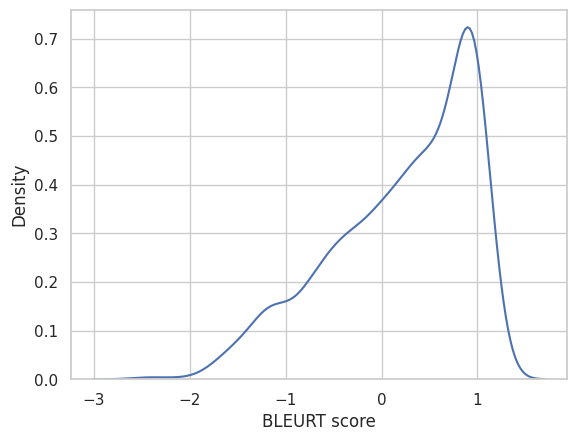

0.20504141283242622

In [ ]:
# # Get distribution of BLEURT scores
# sns.set_theme(style="whitegrid")
# ax = sns.kdeplot(t5_small_optimized_df["pred_BLEURT"]) 
# ax.set(xlabel='BLEURT score', ylabel='Density')
# plt.show()

# # Get mean of BLEURT scores
# t5_small_optimized_df["pred_BLEURT"].mean()

In [ ]:
# # Filter to predictions where BLEURT is below the mean and print out the source, target, prediction, and BLEURT
# print("Predictions where BLEURT is below the mean:")
# pd.set_option('display.max_colwidth', None)
# t5_small_optimized_df[t5_small_optimized_df["pred_BLEURT"] < t5_small_optimized_df["pred_BLEURT"].mean()].head(5).drop(columns=["pred_toxicity", "pred_acceptability", "pred_BERT_score"])

Predictions where BLEURT is below the mean:


,source,target,prediction,pred_BLEURT
2,"Yup then i'll unfollow you, just to be a bitch",Yup then i'll unfollow you.,"Yup then i'll unfollow you, just to be rude",-0.292924
5,What the fuck does that mean? - _ -,What does that mean? - _ -,What does that mean?,0.129286
7,Everyone in trumps orbit steps in shit.,Everyone in trumps orbit finds trouble,Everyone in trumps orbit steps in wrong way.,-0.370640
8,Run on a treadmill and do shit around the house for fucks sakes.,Run on a treadmill and do something around the house.,Run on a treadmill and do things around the house for sakes.,-0.012393
11,"Seriously, who gives a shit about his move.","Seriously, nobody cares about his move.","Seriously, who cares about his move.",-0.099518


In [ ]:
# # Filter to predictions where BLEURT is above the mean and print out the source, target, prediction, and BLEURT
# print("Predictions where BLEURT is above the mean:")
# t5_small_optimized_df[t5_small_optimized_df["pred_BLEURT"] > t5_small_optimized_df["pred_BLEURT"].mean()].head(5).drop(columns=["pred_toxicity", "pred_acceptability", "pred_BERT_score"])

Predictions where BLEURT is above the mean:


,source,target,prediction,pred_BLEURT
0,Rt my bitch got fans give em an autograph smh i love it tho,Rt my girl got fans give em an autograph smh i love it tho,Rt my girl got fans give em an autograph smh i love it tho,1.039630
1,""" redditor for 26 minutes "" fuck off",Redditor for 26 minutes,Redditor for 26 minutes,1.110446
3,And don't say he can't fucking do it.,Don't say he can't do it.,And don't say he can't do it.,0.687012
4,"In the words of george carlin the planet is doing fine, it's the people that are fucked.","In the words of George Carlin “the planet is doing fine, it’s the people that are in trouble”.","In the words of george carlin the planet is doing fine, it's the people that are in trouble.",0.700633
6,"Unfortunately he is a major backer of charlie christ, who is an absolute piece of shit.","Unfortunately he is a major backer of charlie christ, who is not a saint","Unfortunately he is a major backer of charlie christ, who is not good",0.245362


This shows some limitations of BLEURT: The predictions with low BLEURT scores often convey the same meaning to the source / target but are penalized due to differences in words

#### Toxicity evaluation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


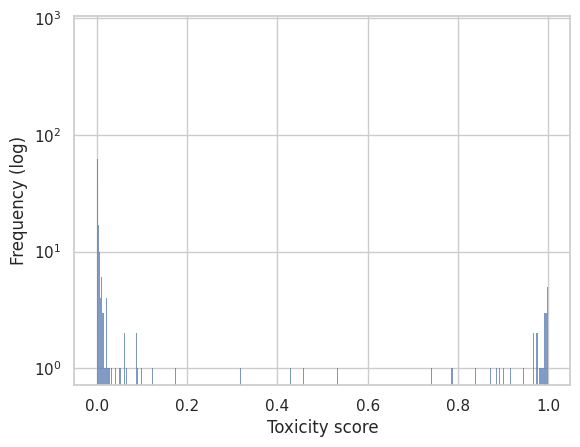

In [ ]:
# # Plot histogram of toxicity scores
# sns.set_theme(style="whitegrid")
# ax = sns.histplot(t5_small_optimized_df["pred_toxicity"])
# ax.set(xlabel='Toxicity score', ylabel='Frequency (log)')
# ax.set_yscale('log')

In [ ]:
# # Get summary statisticas of toxicity scores
# t5_small_optimized_df["pred_toxicity"].describe()

count    1193.000000
mean        0.108309
std         0.294016
min         0.000033
25%         0.000052
50%         0.000179
75%         0.003683
max         0.999541
Name: pred_toxicity, dtype: float64

So most have been detoxified. Next we filter to data where pred_toxicity > 0.8 (still toxic)

In [ ]:
# # Filter to predictions where BLEURT is above the mean and print out the source, target, prediction, and BLEURT
# print("Predictions where toxicity > 0.9")
# t5_small_optimized_df[t5_small_optimized_df["pred_toxicity"] > 0.9].drop(columns=["pred_BLEURT", "pred_acceptability", "pred_BERT_score"])

Predictions where toxicity > 0.9


,source,target,prediction,pred_toxicity,target_toxicity
21,You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks.,There are problems in Chicago that need to be dealt with as well as police brutality.,You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks.,0.990939,0.000759
26,You have cold dead hands.,You have cold hands.,You have cold dead hands.,0.994647,0.070162
27,This is ridiculous and looks terrible if true.,It's ridiculously terrible if true.,This is ridiculous and looks terrible if true.,0.987468,0.042199
33,Ctfu! cause your shxt is just flat like a piece of paper ma niggah,You are not interesting,Cause your shxt is just flat like a piece of paper ma niggah,0.968568,0.003499
37,"Gads, i hate your cruelty.",I don't like your cruelty.,I hate your cruelty.,0.990789,0.021171
...,...,...,...,...,...
1162,Comey was proved to be a liar several times today in his testimony.,Comey was proved that he doesn't say the truth several times today in his testimony.,Comey was proved to be a liar several times today in his testimony.,0.937353,0.000063
1167,Surgeons are bastards but they are shit - hot at their jobs,Surgeons are bad but they are hot at their jobs,Surgeons are bad but they are bad at their jobs,0.977449,0.048145
1173,This law is absolutely asinine.,This law is bad,This law is absolutely asinine.,0.995536,0.000269
1183,You guys are fuckin idiots.,You guys aren't making any sense to me.,You guys are not smart.,0.997295,0.000198


In these examples the target's toxicity is close to 0, suggesting that there are aspects of the text that is still not being detoxified. Indeed there are sentences like "I hate your cruelty" which could have been less toxic had it been converted to something like "I don't like your cruelty"

#### Acceptability evaluation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


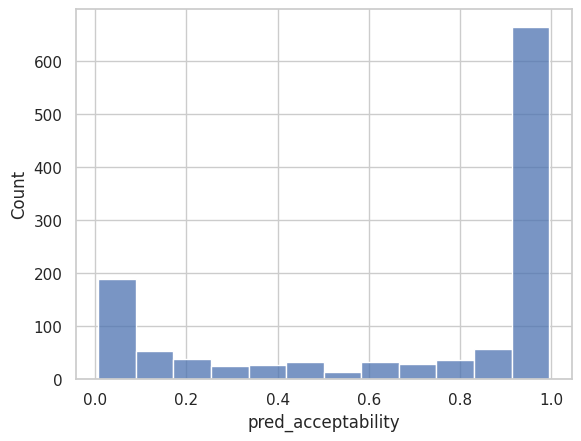

In [ ]:
# # Plot histogram of acceptability scores
# sns.set_theme(style="whitegrid")
# ax = sns.histplot(t5_small_optimized_df["pred_acceptability"])

Majority seems to be linguistically acceptable but there's a big chunk that isn't

In [ ]:
# # Filter to predictions where acceptability is below 0.5 while target_acceptability > 0.5 and print out the source, target, prediction, and acceptability score
# print("Predictions where acceptability < 0.5")
# t5_small_optimized_df[(t5_small_optimized_df["pred_acceptability"] < 0.5) & (t5_small_optimized_df["target_acceptability"] > 0.5)].drop(columns=["pred_BLEURT", "target_toxicity", "pred_toxicity", "pred_BERT_score"])

Predictions where acceptability < 0.5


,source,target,prediction,pred_acceptability,target_acceptability,source_acceptability
4,"In the words of george carlin the planet is doing fine, it's the people that are fucked.","In the words of George Carlin “the planet is doing fine, it’s the people that are in trouble”.","In the words of george carlin the planet is doing fine, it's the people that are in trouble.",0.245888,0.981231,0.317854
7,Everyone in trumps orbit steps in shit.,Everyone in trumps orbit finds trouble,Everyone in trumps orbit steps in wrong way.,0.201212,0.982073,0.943528
33,Ctfu! cause your shxt is just flat like a piece of paper ma niggah,You are not interesting,Cause your shxt is just flat like a piece of paper ma niggah,0.150514,0.964068,0.091120
36,Being first nations in canada is like winning the fucking lottery.,Being the first race in Canada is like winning the lottery.,Being first nations in canada is like winning the lottery.,0.114380,0.990508,0.135966
40,Yourmost stupid comment but i am sure you will do better.,You can do better,Your comment but i am sure you will do better.,0.416758,0.993480,0.320378
...,...,...,...,...,...,...
1157,"But jesus fuck take a few seconds to consider others and idk, not drive while high.","You should take a few seconds to consider others and idk, don't drive while high","But jesus take a few seconds to consider others and idk, not drive while high.",0.069867,0.782699,0.039343
1170,As ive said before ban these drunken idiots from mass flotation.,As I've said before ban these people from mass flotation.,As ive said before ban these people from mass flotation.,0.148892,0.916453,0.456928
1171,Only the freedom caucus is stupid enought to want to do down that route.,Only the freedom caucus will want to go down that route.,Only the freedom caucus is not smart enough to want to do down that route.,0.125802,0.985911,0.084244
1178,""" < - - - imma need ur ass to come back lol",I need you to come back.,I'm need to come back,0.031520,0.992052,0.115100


So it looks like in many cases where prediction is not linguistically acceptable, the source also scores low in terms of acceptability. In contrast, the target text in these cases seem to be fixing the grammar / fluency of the source text as well

#### BERT evaluation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


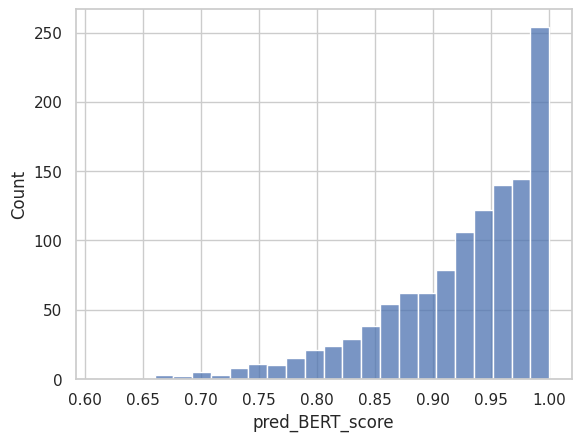

In [ ]:
# # Plot histogram of BERT scores
# sns.set_theme(style="whitegrid")
# ax = sns.histplot(t5_small_optimized_df["pred_BERT_score"])

All the BERT F1 scores are above 0.5, suggesting they retain the semantic similarity of the targets. To confirm, we will just look at those with BERT score under 0.80

In [ ]:
# # Filter to predictions where BERT score is below 0.8 and print out the source, target, prediction, and BERT score
# print("Predictions where BERT score < 0.5")
# t5_small_optimized_df[t5_small_optimized_df["pred_BERT_score"] < 0.8].drop(columns=["pred_BLEURT", "target_toxicity", "target_acceptability", "source_acceptability", "pred_toxicity", "pred_acceptability"])

Predictions where BERT score < 0.5


,source,target,prediction,pred_BERT_score
16,Buychrisbrownfamealbum if u following him and he never tweetcho ass back,Buy Chris brown fame album if you are following him and he never tweet you back.,Buychrisbrownfamealbum if u following him and he never tweetcho back,0.797463
21,You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks.,There are problems in Chicago that need to be dealt with as well as police brutality.,You straighten out that chicago problem and then well tell our cops to stop killing unarmed blacks.,0.750688
33,Ctfu! cause your shxt is just flat like a piece of paper ma niggah,You are not interesting,Cause your shxt is just flat like a piece of paper ma niggah,0.722022
42,Bitch make me! i do what? i'm confused - _ -,"Im sorry,I am confused.",Make me! i do what? i'm confused - _ -,0.738124
56,Naw the industy got em fucked up,The industry made me annoyed,Naw the industy got em messed up,0.741795
...,...,...,...,...
1115,"Lmfaoo now she texted me saying "" i want your ginger pussy and my choclate pussy together",She's texting dirty things,"Lmfaoo now she texted me saying "" i want your ginger and my choclate together",0.719809
1137,"Oh fuck off, edgy kid.",Please leave me alone.,"Oh go away, edgy kid.",0.726419
1147,"Kuss that nigga lyingg, i was high as hell bhut i ain't do all 'lhat lol","Because that person is lying, I was high but I didn't do all that.",I was high and I ain't do all 'lhat lol,0.793282
1156,Niggas is crazy you can't trust em provenfact,They are unusual and you cannot trust them.,Niggas is crazy you can't trust em provenfact,0.791288


Those with BERT score under 0.8 appear to retain the meaning of the target material

# Fine-tune T5 Model (Bi-directional, No custom loss)

In [21]:
# Create dataset for bi-directional model
raw_datasets = DatasetDict.load_from_disk(RAW_DATASET_PATH)
raw_datasets

def create_bidirectional_dataset(dataset):

    def bidirectional_extension(dataset):
        new_data = {
            "source": [f"to_neutral: {x}" for x in dataset['source']] + [f"to_toxic: {x}" for x in dataset['target']],
            "target": dataset['target'] + dataset['source']
        }
        return new_data

    extended_train_data = bidirectional_extension(raw_datasets["train"])
    extended_validation_data = bidirectional_extension(raw_datasets["validation"])
    extended_test_data = bidirectional_extension(raw_datasets["test"])

    extended_datasets = DatasetDict({
        "train": Dataset.from_dict(extended_train_data),
        "validation": Dataset.from_dict(extended_validation_data),
        "test": Dataset.from_dict(extended_test_data)
    })

    extended_datasets = extended_datasets.shuffle(seed=RANDOM_SEED)

    return extended_datasets

raw_datasets_bd = create_bidirectional_dataset(raw_datasets)

# Save indices of neutral and toxic data
def get_indices(dataset):
    """
    Saves the indices of data that is to_neutral and to_toxic.
    """
    to_neutral_idx = []
    to_toxic_idx = []
    for i in range(len(dataset)):
        if dataset[i]["source"].startswith("to_neutral"):
            to_neutral_idx.append(i)
        else:
            to_toxic_idx.append(i)

    return to_neutral_idx, to_toxic_idx

# to_neutral_idx_train, to_toxic_idx_train = get_indices(raw_datasets_bd["train"])
# to_neutral_idx_val, to_toxic_idx_val = get_indices(raw_datasets_bd["validation"])
# to_neutral_idx_test, to_toxic_idx_test = get_indices(raw_datasets_bd["test"])

# # Check that the indices are correct
# print(raw_datasets_bd["train"][to_neutral_idx_train[:5]]["source"])
# print(raw_datasets_bd["train"][to_toxic_idx_train[:5]]["source"])

# Apply the preprocessing function to the datasets
tokenized_datasets_bd = raw_datasets_bd.map(
    preprocess_function,
    batched=True,
    remove_columns=["source", "target"],
)

data_collator = DataCollatorForSeq2Seq(tokenizer_t5, model_t5, return_tensors="pt", padding=True)

Map:   0%|          | 0/21466 [00:00<?, ? examples/s]

Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

In [22]:
# Define compute metrics function
def compute_metrics_bd(eval_preds, dataset_type):
    """
    Function to calculate the metrics for trainer.evaluate().
    This function is for the bi-directional model.
    dataset_type has to be passed in using functools.

    Args:
        eval_preds (tuple): Tuple containing the predictions and labels
        dataset_type (str): Type of dataset (train, validation, or test)

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer_t5.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    refs = np.where(refs != -100, refs, tokenizer_t5.pad_token_id)
    decoded_refs = tokenizer_t5.batch_decode(refs, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_refs = [ref.strip() for ref in decoded_refs]
    
    # Get the indices to use when splitting predictions and refs to to_neutral and to_toxic
    to_neutral_idx, to_toxic_idx = get_indices(raw_datasets_bd[dataset_type])

    # # Split the predictions and test into to_neutral and to_toxic based on the indices (neutral_indices_validation and toxic_indices_validation)
    to_neutral_preds = [decoded_preds[i] for i in to_neutral_idx]
    # to_toxic_preds = [decoded_preds[i] for i in to_toxic_idx]
    to_neutral_refs = [decoded_refs[i] for i in to_neutral_idx]
    # to_toxic_refs = [decoded_refs[i] for i in to_toxic_idx]
    
    # Evaluate metrics for to_neutral
    to_neutral_metrics = evaluate_metrics(
        to_neutral_refs,
        to_neutral_preds,
        tokenizer_toxicity=tokenizer_toxicity,
        model_toxicity=model_toxicity,
        tokenizer_acceptability=tokenizer_acceptability,
        model_acceptability=model_acceptability,
        to_neutral=True,
        include_bleurt=False
    )

    # Return dictionary of to_neutral metrics
    return to_neutral_metrics

In [24]:
trainer_t5_small_bd = setup_trainer(
    num_train_epochs=20, # Previously tried 10 but it was still improving
    output_dir_name="t5-small-detoxify-bd",
    train_dataset=tokenized_datasets_bd["train"],
    eval_dataset=tokenized_datasets_bd["validation"],
    compute_metrics=partial(compute_metrics_bd, dataset_type="validation"),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Typically patience is 10% of number of epochs
    )

wandb.init(project="w266_final_project", name="t5-small-bd-detoxify")
trainer_t5_small_bd.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Bleu,Sta Preds,Sta Pct,Acceptability Preds,Acceptability Pct,Bert Score F1,Overall
1,1.490900,1.218165,0.596864,0.815591,0.855009,0.692316,0.966816,0.921328,0.839005
2,1.254400,1.165401,0.604312,0.875943,0.918278,0.696026,0.971997,0.924443,0.867462


# Fine-tune T5 Model (Bi-directional, with Custom Loss)

Documentation for original loss function:

https://huggingface.co/transformers/v4.2.2/_modules/transformers/trainer.html#Trainer.compute_loss

In [ ]:
# def compute_loss(self, model, inputs):
#         """
#         How the loss is computed by Trainer. By default, all models return the loss in the first element.

#         Subclass and override for custom behavior.
#         """
#         outputs = model(**inputs)
#         # Save past state if it exists
#         # TODO: this needs to be fixed and made cleaner later.
#         if self.args.past_index >= 0:
#             self._past = outputs[self.args.past_index]

#         if self.label_smoother is not None and "labels" in inputs:
#             return self.label_smoother(outputs, inputs["labels"])
#         else:
#             # We don't use .loss here since the model may return tuples instead of ModelOutput.
#             return outputs["loss"] if isinstance(outputs, dict) else outputs[0]

In [ ]:
# class Seq2SeqTrainerCustomLoss(Seq2SeqTrainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         """
#         Compute custom loss for the model.

#         Args:
#             model (torch.nn.Module): The model training or evaluating.
#             inputs (dict): The inputs and targets of the model.
#             return_outputs (bool): Whether to return model outputs.

#         Returns:
#             torch.FloatTensor: The loss value.
#         """
#         # Call prediction_step
#         loss, encoded_y_pred, encoded_y_test = self.prediction_step(model, inputs, prediction_loss_only=False)
    
#         # Decode the generated tokens
#         if isinstance(encoded_y_pred, tuple):
#             encoded_y_pred = encoded_y_pred[0]
#         decoded_y_pred = self.tokenizer.batch_decode(encoded_y_pred, skip_special_tokens=True)

#         # Decode the labels
#         ## Replace -100s in the labels as we can't decode them
#         encoded_y_test = torch.where(encoded_y_test != -100, encoded_y_test, torch.tensor(self.tokenizer.pad_token_id))
#         decoded_y_test = self.tokenizer.batch_decode(encoded_y_test, skip_special_tokens=True)

#         # Some simple post-processing
#         decoded_y_pred = [pred.strip() for pred in decoded_y_pred]
#         decoded_y_test = [label.strip() for label in decoded_y_test]
        
#         # Calculate metrics
#         # TO DO: MAKE THIS WORK WITH PYTORCH LIGHTNING
#         composite_score = evaluate_metrics(
#             decoded_y_test,
#             decoded_y_pred,
#             tokenizer_toxicity=tokenizer_toxicity,
#             model_toxicity=model_toxicity,
#             tokenizer_acceptability=tokenizer_acceptability,
#             model_acceptability=model_acceptability,
#             include_bleurt=False
#         )['Overall']

#         # # Composite score will be on a scale of 0 - 1, so we can invert it to get the loss
#         custom_loss = torch.tensor(1 - composite_score, dtype=torch.float, requires_grad=True, device=self.args.device)

#         print(custom_loss)
#         return custom_loss
    
# def setup_trainer(model_name_t5="t5-small",
#                 per_device_train_batch_size=64,
#                 per_device_eval_batch_size=64,
#                 learning_rate=3e-4,
#                 weight_decay=0.01,
#                 num_train_epochs=10,
#                 max_length=50,
#                 num_beams=4):
    
#     # Define generation config
#     generation_config = GenerationConfig(
#         max_length=max_length,
#         num_beams=num_beams,
#         eos_token_id=tokenizer_t5.eos_token_id,
#         bos_token_id=tokenizer_t5.bos_token_id,
#         pad_token_id=tokenizer_t5.pad_token_id,
#         decoder_start_token_id=tokenizer_t5.pad_token_id)

#     # Save the generation config
#     GEN_CONFIG_PATH = "../models/t5-small-detoxify-cl/generation_config"
#     generation_config.save_pretrained(GEN_CONFIG_PATH)

#     # Define the training arguments
#     args = Seq2SeqTrainingArguments(
#         output_dir=f'../models/{model_name_t5}_detoxify_cl',
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         logging_strategy="epoch",
#         save_total_limit=1,
#         num_train_epochs=num_train_epochs,
#         per_device_train_batch_size=per_device_train_batch_size,
#         per_device_eval_batch_size=per_device_eval_batch_size,
#         learning_rate=learning_rate, 
#         weight_decay=weight_decay,
#         predict_with_generate=True,
#         generation_config=GEN_CONFIG_PATH,
#         fp16=True,
#         report_to="wandb",
#         logging_steps=100,
#         load_best_model_at_end=True,
#         metric_for_best_model="Overall",
#         greater_is_better=True,
#     )

#     # Reinstantiate the model
#     model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)

#     # Instantiate the trainer
#     trainer = Seq2SeqTrainerCustomLoss(
#         model = model_t5,
#         args = args,
#         train_dataset=tokenized_datasets["train"],
#         eval_dataset=tokenized_datasets["validation"],
#         data_collator=data_collator,
#         tokenizer=tokenizer_t5,
#         compute_metrics=compute_metrics,
#     )

#     return trainer

# trainer_t5_small_cl= setup_trainer()
# trainer_t5_small_cl.train()

tensor(0.7442, device='cuda:0', requires_grad=True)


AssertionError: No inf checks were recorded for this optimizer.

# Fine-Tune T5 Model (With Negative Word List)